# Preprocessing and Modeling Pipeline

In this file, I put together a Spark pipeline that does the following:
- Preprocessing
    - Engineer the txn_fee feature using VectorAssembler and FeeCalculator (custom transformer)
    - Aggregate the data into a given frequency ("daily" or "block") using FeeAggregator (custom transformer)

- Modeling
    - Creates lagged columns using LagShifter (custom transformer)
    - Assembles a features column using VectorAssembler
    - LinearRegressor
    
I built a custom train-test split function and use it for testing out-of sample performance of the model. Then I tuned model hyperparameters using a custom grid search function.

In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
spark.version

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1684871409893_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'3.0.1-amzn-0'

In [ ]:
%%capture
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("matplotlib==3.2.1")

# Custom transformer classes

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, StringType
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# FeeCalculator:
# Custom Transformer wrapper class for compute_txn_fee
# requires a single input column formatted as [gas, gas_price]

def compute_txn_fee(gas_and_price):
    """
    gas: gas units used by txn
    gas_price: price of each unit of gas in wei (1/10^18 ETH)
    returns: txn fee measured in ETH
    """
    
    gas, gas_price = map(float, gas_and_price)
    
    return gas * gas_price / 1.0e18


class FeeCalculator(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):

    @keyword_only
    def __init__(self, inputCol='gas_and_price', outputCol='txn_fee'):
        super().__init__()
        self._setDefault(inputCol='gas_and_price', outputCol='txn_fee')
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
  
    @keyword_only
    def setParams(self, inputCol=None, outputCol='txn_fee'):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def setInputCol(self, new_inputCol):
        return self.setParams(inputCol=new_inputCol)
  
    def setOutputCol(self, new_outputCol):
        return self.setParams(outputCol=new_outputCol)
  
    def _transform(self, dataset):
        input_column = dataset[self.getInputCol()]
        output_column = self.getOutputCol()
        udf_func = udf(compute_txn_fee, DoubleType())
        return dataset.withColumn(output_column, udf_func(input_column))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# FeeAggregator: 
# Custom Transformer wrapper class for df.groupby("frequency").sum("txn_fee")

class FeeAggregator(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    
    frequency = Param(Params._dummy(), 
                      "frequency", 
                      "frequency of groupby aggregation - choose 'block' or 'daily'",
                      typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, inputCol='txn_fee', outputCol=None, frequency=None):
        super().__init__()
        self._setDefault(frequency='daily')
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
  
    @keyword_only
    def setParams(self, inputCol='txn_fee', outputCol=None, frequency=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def setInputCol(self, new_inputCol):
        return self.setParams(inputCol=new_inputCol)
  
    def setOutputCol(self, new_outputCol):
        return self.setParams(outputCol=new_outputCol)
    
    def setFrequency(self, new_frequency):
        return self.setParams(frequency=new_frequency)
    
    def getFrequency(self):
        return self.getOrDefault(self.frequency)
  
    def _transform(self, dataset):
        # input column should be txn_fee
        input_column = self.getInputCol()
        if input_column != 'txn_fee':
            raise ValueError("input should be txn_fee")
        
        freq = self.getFrequency()
        
        if freq == 'daily':
            groupbyCol = 'date'
            sortbyCol = 'date'
        elif freq == 'block':
            groupbyCol = ['block_number', 'block_timestamp', 'block_hash', 'date']
            sortbyCol = 'block_number'
        else:
            raise ValueError("choose 'block' or 'daily' for frequency")
                             
        return dataset.groupBy(groupbyCol).sum(input_column) \
                     .withColumnRenamed("sum(txn_fee)", "txn_fee") \
                     .sort(sortbyCol)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# LagShifter:
# Adds columns to the dataframe shifted by time indices from 1 to lags (parameter)

from pyspark.sql.functions import lag, lit, row_number
from pyspark.sql.window import Window

class LagShifter(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    
    lags = Param(Params._dummy(), 
                      "lags", 
                      "set number of lags, default is 1",
                      typeConverter=TypeConverters.toInt)
    
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, lags=None):
        super().__init__()
        self._setDefault(lags=1)
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
        self.FeatureNames = []
    
    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, lags=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def setInputCol(self, new_inputCol):
        return self.setParams(inputCol=new_inputCol)
  
    def setOutputCol(self, new_outputCol):
        return self.setParams(outputCol=new_outputCol)
    
    def setLags(self, new_lags):
        # reset FeatureNames along lags 
        self.FeatureNames = []
        col_name = self.getInputCol()
        for i in range(new_lags):
            strLag = col_name +'_lag' + str(i+1)
            self.FeatureNames.append(strLag)
        return self.setParams(lags=new_lags)
    
    def getLags(self):
        return self.getOrDefault(self.lags)
    
    def transform(self, dataset):
        # transforms the spark dataframe and creates columns
        # that have time-lagged values
        
        self.FeatureNames = []
        # sort by first column, which should be either 'date' or 'block_number'
        idxCol = dataset.columns[0] 
        mywindow = Window.orderBy(idxCol)
        col_name = self.getInputCol()
        for i in range(self.getLags()):
            strLag = col_name +'_lag' + str(i+1)
            dataset = dataset.withColumn(strLag,lag(\
                               dataset[col_name], i+1).over(mywindow))
            self.FeatureNames.append(strLag)
        
        # remove first n rows with null values
        dataset = dataset.withColumn('row_num', row_number().over(mywindow))
        dataset = dataset.filter(dataset.row_num > self.getLags())
        dataset = dataset.drop('row_num')
        return dataset.sort(idxCol)
    
    def getFeatureNames(self):
    # this return the names of feature-columns that are
    # generated by transform method
        return self.FeatureNames

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Pipeline with custom parameters

In [8]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

def build_pipeline(frequency='daily', lags=1, include_regression=True):
    
    # VectorAssembler: combines 'receipt_gas_used' and 'receipt_effective_gas_price'
    gasPriceAssembler = VectorAssembler() \
        .setInputCols(['receipt_gas_used', 'receipt_effective_gas_price']) \
        .setOutputCol('gas_and_price')
    
    # FeeCalculator: Custom Transformer wrapper class for compute_txn_fee
    feeCalculator = FeeCalculator() \
        .setInputCol('gas_and_price') \
        .setOutputCol('txn_fee')

    # FeeAggregator: Custom Transformer wrapper class for df.groupby("frequency").sum("txn_fee")
    feeAggregator = FeeAggregator() \
        .setInputCol('txn_fee') \
        .setFrequency(frequency)
    
    # LagShifter: Adds columns to the dataframe shifted by time indices from 1 to lags (parameter)
    lagShifter = LagShifter() \
        .setInputCol('txn_fee') \
        .setLags(lags)
    
    features = lagShifter.getFeatureNames()

    # Feature assembler
    featureAssembler = VectorAssembler() \
        .setInputCols(features) \
        .setOutputCol('features')
    
    # collecting stages
    stages=[gasPriceAssembler,
            feeCalculator,
            feeAggregator,
            lagShifter,
            featureAssembler
            ]
    
    # Linear regression estimator
    if include_regression:
        linearRegressor = LinearRegression() \
            .setFeaturesCol('features') \
            .setLabelCol('txn_fee') \
            .setMaxIter(10)
        stages.append(linearRegressor)

    pipeline = Pipeline(stages=stages)
    
    return pipeline

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Train test split (custom)

Since random splits would cause forward-looking bias for time series modeling, I build a custom train-test split function which splits the dataset by time index. This is similar to the idea of `TrainValidation` in Spark, where the dataset is only split once into a train, test pair.

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

def TimeSeriesSplit(df, split_ratio=0.8, frequency='daily'):
    """
    Splits time series dataset into an initial training dataset and a later testing dataset
    """
    
    # Sort by time
    if frequency == 'daily':
        orderByCol = 'date'
    elif frequency == 'block':
        orderByCol = 'block_number'
    df = df.sort(orderByCol)    
    
    # Create a row number for each row
    w = Window().orderBy(orderByCol)
    df = df.withColumn("row_num", row_number().over(w))

    # Calculate the split point
    total_rows = df.count()
    train_rows = int(total_rows * split_ratio)

    # Get the value of the orderByCol at the split point
    split_row_num = df.where(df.row_num == train_rows).select(orderByCol).collect()[0][0]

    # Split the data ensuring that all data from a specific day or block is included in either the training set or the test set
    df_train = df.where(df[orderByCol] <= split_row_num)
    df_test = df.where(df[orderByCol] > split_row_num)

    # Remove the row number column
    df_train = df_train.drop("row_num")
    df_test = df_test.drop("row_num")

    return df_train, df_test


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Test run: AR(1) with OLS, daily frequency

In [10]:
# load data
from pyspark.sql.functions import col
start_date = '2021-09-01'
end_date = '2023-05-01'
data = spark.read.parquet("s3://aws-public-blockchain/v1.0/eth/transactions/") \
                    .where(col('date').between(start_date, end_date)) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# train-test split on raw data
train, test = TimeSeriesSplit(data, split_ratio=0.8, frequency='daily')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# OLS training
# pipeline (default parameters of the LinearRegression class yields OLS)
ols_pl = build_pipeline(frequency='daily', lags=1)
# don't need standardization for OLS
ols_pl.getStages()[-1].setStandardization(False)

# fitting model with training data
ols_pl_mod = ols_pl.fit(train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# prediction
# save predictions in memory
ols_train_forecast = ols_pl_mod.transform(train).persist()
ols_test_forecast = ols_pl_mod.transform(test).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# estimated parameters
ols_coefs = ols_pl_mod.stages[-1].coefficients
ols_intercept = ols_pl_mod.stages[-1].intercept

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Evaluation with RMSE
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator() \
            .setPredictionCol('prediction') \
            .setLabelCol('txn_fee') \
            .setMetricName('rmse')
ols_train_RMSE = evaluator.evaluate(ols_train_forecast)
ols_test_RMSE = evaluator.evaluate(ols_test_forecast)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# print OLS results
print("Results for AR(1) with OLS, daily frequency")
print(f"RMSE for training data: {ols_train_RMSE}")
print(f"RMSE for testing data: {ols_test_RMSE}")
print(f"OLS coefs: c={ols_intercept:.4f}, rho_1={ols_coefs[0]:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Results for AR(1) with OLS, daily frequency
RMSE for training data: 4739.586307761658
RMSE for testing data: 1673.2433590235746
OLS coefs: c=2631.3209, rho_1=0.5940

In [17]:
# visualize forecast - convert to pandas
import pandas as pd
import matplotlib.pyplot as plt

ols_train_forecast_pd = ols_train_forecast.toPandas()
ols_test_forecast_pd = ols_test_forecast.toPandas()
continuous_forecast = pd.concat([ols_train_forecast_pd, ols_test_forecast_pd])
continuous_forecast = continuous_forecast.sort_values(by='date')
test_start_date = ols_test_forecast_pd['date'].min()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# plot
plt.figure(figsize=(16,8))
plt.plot(continuous_forecast['date'], continuous_forecast['txn_fee'], label='Actual')
plt.plot(continuous_forecast['date'], continuous_forecast['prediction'], label='Prediction')
plt.axvline(x=test_start_date, color='k', linestyle='--', label='start of test period')
plt.xlabel('Date')
plt.ylabel('txn_fee')
plt.legend()
plt.title('Forecast performance - AR(1) OLS')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

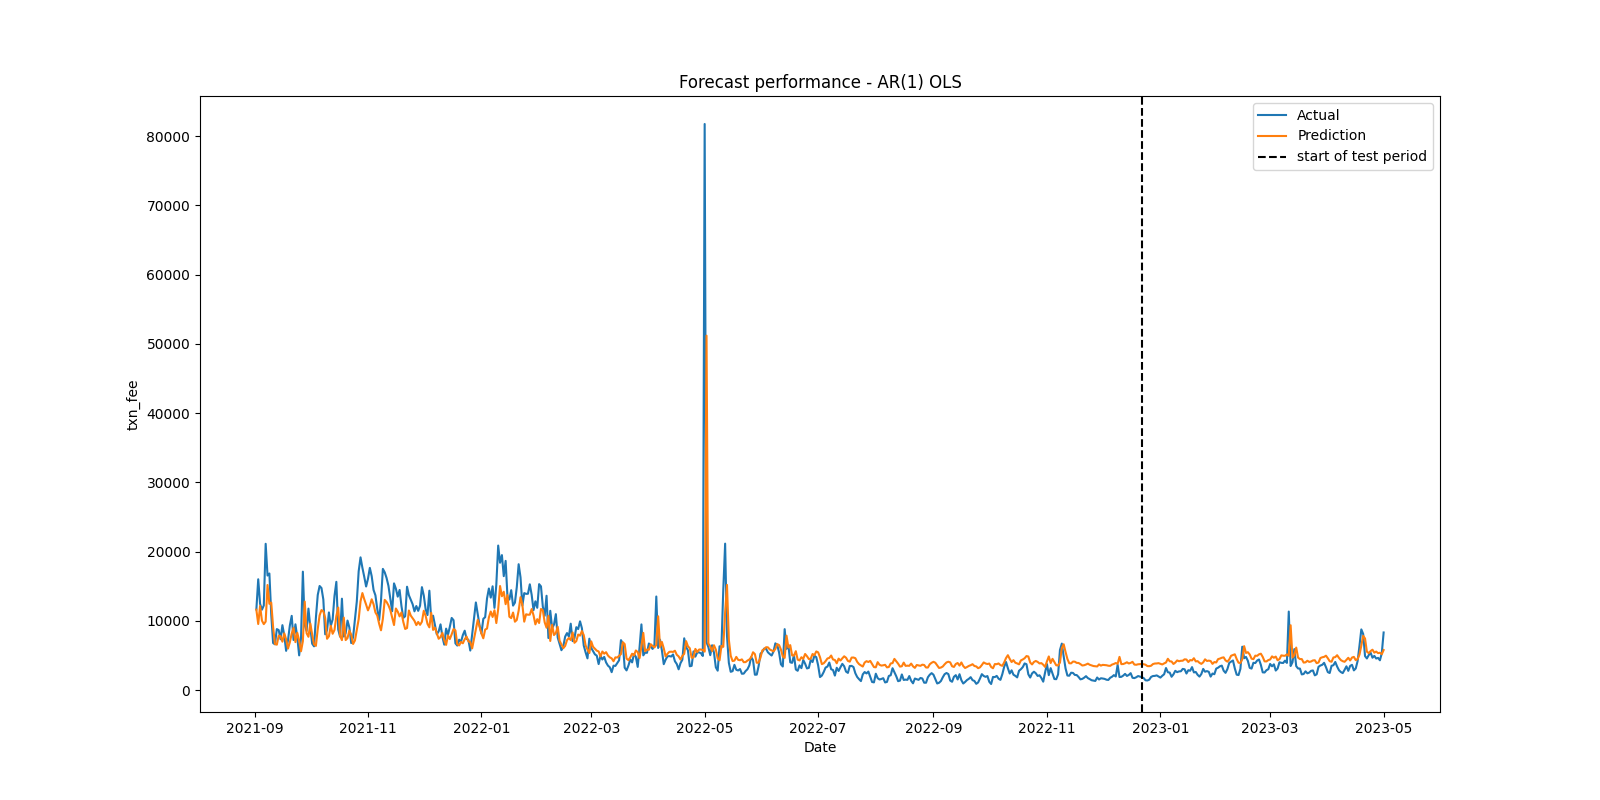

In [20]:
%matplot plt

In [21]:
# remove forecast data from memory
ols_train_forecast.unpersist()
ols_test_forecast.unpersist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[date: date, txn_fee: double, txn_fee_lag1: double, features: vector, prediction: double]

# Hyperparameter tuning
The hyperparameters are: *regParam ($\lambda$)*, *elasticNetParam ($\alpha$)*, and *lags*. Since a three-dimensional grid is too computationally intensive, I specify a large number for lags, generating many features, then use the two regularization parameters to suppress some of the features. The result should mimic if the *lags* parameter is also tuned.  
For reasons mentioned above, I use single-fold validation with the previously defined training and testing datasets.  
To avoid transforming the dataset from raw multiple repeatedly, I build a smaller pipeline with all the required data transformation, and only repeat the training and evaluation part.

In [41]:
# Hyperparam tuning for Linear regression
import numpy as np

def LRTuning(train_data, test_data, features_col='features', label_col='txn_fee', 
             lambda_grid=None, alpha_grid=None, metric_name='rmse',
             print_progress=False):
    
    """
    Performs grid search hyperparameter tuning for linear regression model
    train_data, test_data: dataframe with column 'features' and 'txn_fee'
    lambda_grid, alpha_grid: iterable of parameter values to search over
    metric_name: evaluation metric, default is rmse
    """
    
    # check if features and label column exist
    required_columns = [features_col, label_col]
    for col_name in required_columns:
        if col_name not in train_data.columns:
            raise ValueError(f"Column '{col_name}' not found in train_data.")
        if col_name not in test_data.columns:
            raise ValueError(f"Column '{col_name}' not found in test_data.")
            
    # default search grid
    if lambda_grid is None:
        lambda_grid = np.arange(0.0, 0.1, 0.01) # regularization param (penalty rate)
    if alpha_grid is None:
        alpha_grid = [0,1] # elastic net param, 0 = ridge(L1 penalty), 1 = Lasso(L2 penalty)
    
    
    # dict for storing all tuning data
    tuning_data = {'param_values' : [],# a list of dicts, similar to Spark CV's EstimatorParamMaps
                   'param_metrics' : [], # a list of metrics, similar to Spark CV's (avg)Metrics 
                   'model_coefs' : [] # a list of arrays containing model coefficents
                   }
    
    # Evaluator
    LREvaluator = RegressionEvaluator() \
            .setPredictionCol('prediction') \
            .setLabelCol('txn_fee') \
            .setMetricName(metric_name)
    
    # Grid search (sequentially computed)
    for lam in lambda_grid:
        for alp in alpha_grid:
            
            # Record current parameters
            curr_params = {'regParam' : lam, 'elasticNetParam' : alp}
            tuning_data['param_values'].append(curr_params)
            
            # Define regressor with current parameter set
            linearRegressor = LinearRegression() \
                    .setFeaturesCol(features_col) \
                    .setLabelCol(label_col) \
                    .setMaxIter(10) \
                    .setRegParam(lam) \
                    .setElasticNetParam(alp) \
                    .setFitIntercept(True)
            
            # Fit model
            lr_model = linearRegressor.fit(train_data)
            intercept = lr_model.intercept
            coefs = lr_model.coefficients
            all_coefs = np.concatenate([np.array([intercept]), coefs.toArray()])
            tuning_data['model_coefs'].append(all_coefs)
            
            # Forecasting and evaluation (only on test data)
            test_forecast = lr_model.transform(test_data).persist() # persist for faster evaluation
            test_metric = LREvaluator.evaluate(test_forecast)
            tuning_data['param_metrics'].append(test_metric)
            test_forecast.unpersist()
            
            if print_progress:
                print(f"Completed training and evaluation for parameter set {curr_params}")
    
    # decide best parameters
    if metric_name in ['rmse', 'mse', 'mae']:
        opt_func = np.argmin
    elif metric_name in ['r2']:
        opt_func = np.argmax
    else:
        raise ValueError("Evaluation metric not recognized. Use 'rmse', 'mse', 'mae', or 'r2'.")
        
    # retrive data from tuning_data dictionary
    best_param_idx = opt_func(tuning_data['param_metrics'])
    best_param_values = tuning_data['param_values'][best_param_idx]
    best_param_metrics = tuning_data['param_metrics'][best_param_idx]
    best_model_coefs = tuning_data['model_coefs'][best_param_idx]
    
    return tuning_data, best_param_values, best_param_metrics, best_model_coefs
    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# preprocessing pipeline: generates transformed dataset with features column
daily_preproc_pl = build_pipeline(frequency='daily', lags=5, include_regression=False)
#block_preproc_pl = build_pipeline(frequency='block', lags=5, include_regression=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# transformed datasets 
# recycle the raw train, test datasets from baseline model, 
# the split was according to date so no need to split again on block level
raw_train = train
raw_test = test

# save transformed data - daily
daily_preproc_pl_mod = daily_preproc_pl.fit(raw_train)
daily_train = daily_preproc_pl_mod.transform(raw_train).persist()
daily_test = daily_preproc_pl_mod.transform(raw_test).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
# tuning
daily_results = LRTuning(train_data=daily_train,
                         test_data=daily_test,
                         features_col='features', 
                         label_col='txn_fee',
                         lambda_grid = np.arange(0.0, 0.1, 0.01),
                         alpha_grid = [0,1],
                         metric_name='rmse')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
# print results
np.set_printoptions(precision=4)
print("Model tuning results (frequency=daily):")
print(f"Hyperparameters: {daily_results[1]}")
print(f"RMSE: {daily_results[2]}")
print(f"Model coefficients: {daily_results[3]}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model tuning results (frequency=daily):
Hyperparameters: {'regParam': 0.01, 'elasticNetParam': 1}
RMSE: 1210.202231603424
Model coefficients: [1.0336e+03 2.9529e-01 1.6690e-01 1.2075e-01 1.2564e-01 1.2404e-01]

The best model is a Lasso model. Compared to the baseline OLS model (RMSE=1673.24), the tuned model is much better.

In [52]:
# forecast with the best model
bestRegressor = LinearRegression() \
        .setFeaturesCol('features') \
        .setLabelCol('txn_fee') \
        .setMaxIter(10) \
        .setRegParam(daily_results[1]['regParam']) \
        .setElasticNetParam(daily_results[1]['elasticNetParam']) \
        .setFitIntercept(True)
best_mod = bestRegressor.fit(daily_train)
best_train_forecast = best_mod.transform(daily_train)
best_test_forecast = best_mod.transform(daily_test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
best_train_forecast_pd = best_train_forecast.toPandas()
best_test_forecast_pd = best_test_forecast.toPandas()
continuous_forecast = pd.concat([best_train_forecast_pd, best_test_forecast_pd])
continuous_forecast = continuous_forecast.sort_values(by='date')
test_start_date = ols_test_forecast_pd['date'].min()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
# plot
plt.figure(figsize=(16,8))
plt.plot(continuous_forecast['date'], continuous_forecast['txn_fee'], label='Actual')
plt.plot(continuous_forecast['date'], continuous_forecast['prediction'], label='Prediction')
plt.axvline(x=test_start_date, color='k', linestyle='--', label='start of test period')
plt.xlabel('Date')
plt.ylabel('txn_fee')
plt.legend()
plt.title('Forecast performance - Tuned LR model')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

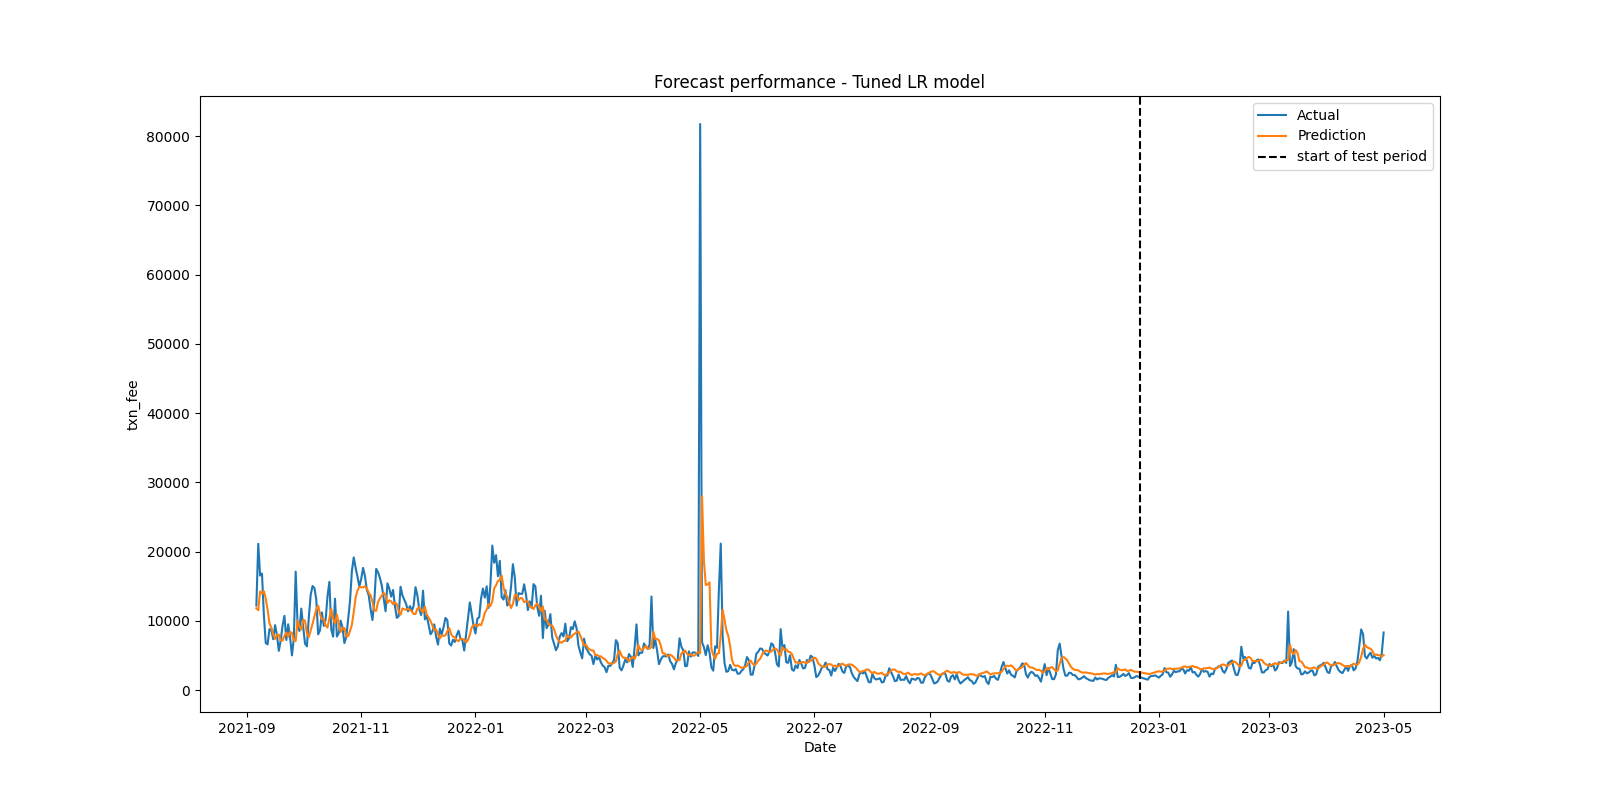

In [59]:
%matplot plt

In [71]:
# side-by-side comparison of OLS and tuned Lasso
figure = plt.figure(figsize=(16,8))
plt.plot(best_test_forecast_pd['date'], best_test_forecast_pd['txn_fee'], label='Actual')
plt.plot(ols_test_forecast_pd['date'], ols_test_forecast_pd['prediction'], label='Prediction (baseline)')
plt.plot(best_test_forecast_pd['date'], best_test_forecast_pd['prediction'], label='Prediction (tuned)')
#plt.axvline(x=test_start_date, color='k', linestyle='--', label='start of test period')
plt.xlabel('Date')
plt.ylabel('txn_fee')
plt.legend()
plt.title('Comparing forecast performance in test period')
figure.autofmt_xdate()
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

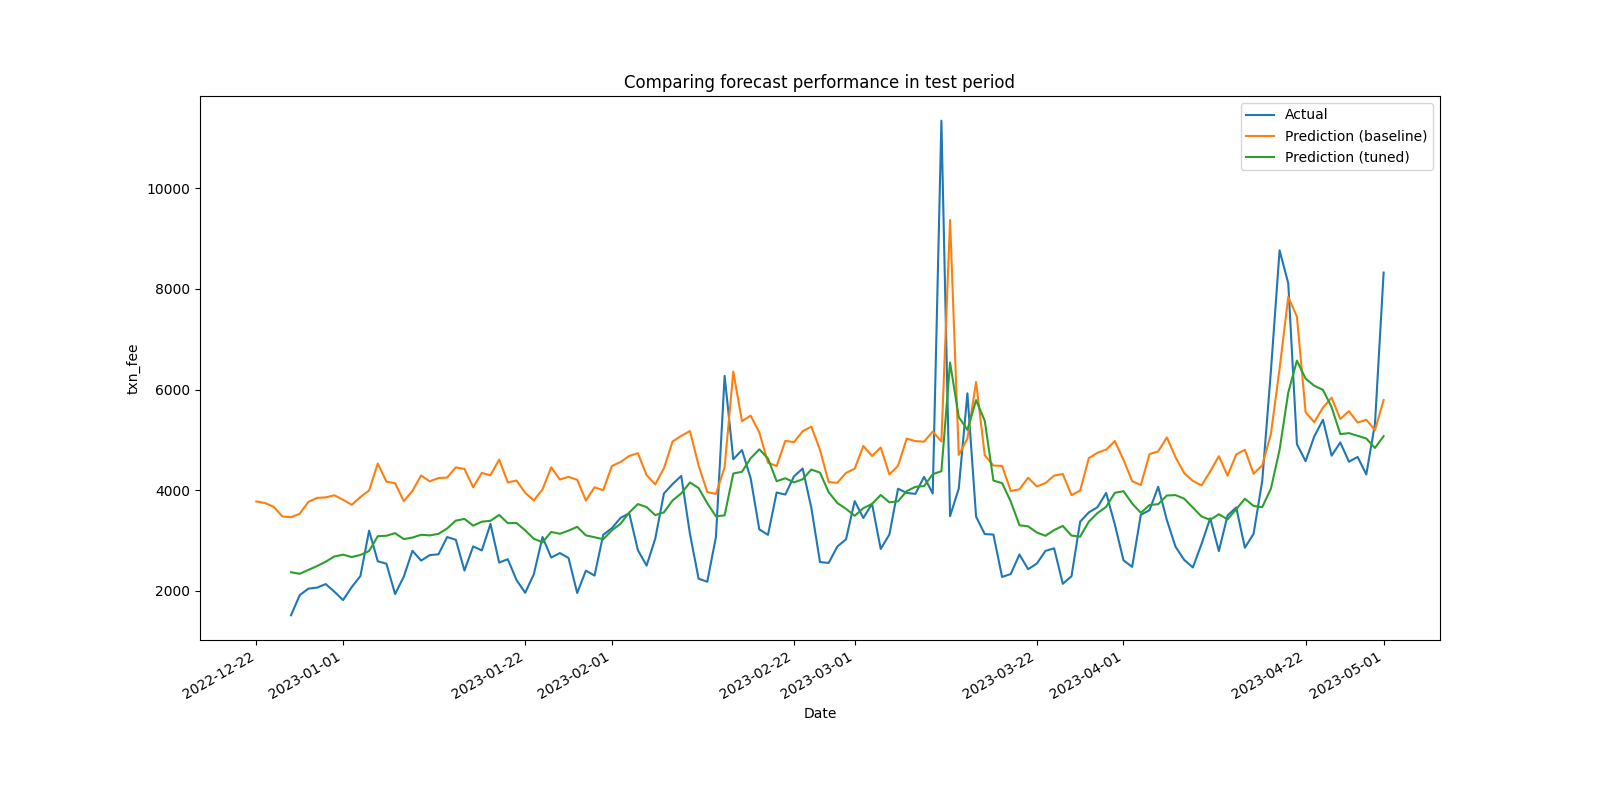

In [72]:
%matplot plt

From a technical standpoint, the baseline AR(1) model gives higher weight to sample mean, so the large outliers in the sample had a negative impact on the baseline model's performance.

In [ ]:
daily_train.unpersist()

In [ ]:
# to run block-level data, repeat with:
block_train = block_preproc_pl.transform(raw_train).persist()